In [1]:
%load_ext autoreload

%autoreload 2

import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join

import joblib
from concurrent.futures import ProcessPoolExecutor

from backports import tempfile

%matplotlib inline
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
matplotlib.rcParams["image.composite_image"]=False
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.linalg
from numpy.fft import rfft, irfft, fft, ifft

import multiprocessing
import concurrent.futures

import psrchive
import residuals

import pipe
from pipe import rotate_phase, convert_template, align_profile, align_scale_profile

import template_match as tm

plt.viridis()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [2]:
SMALL_SIZE = 7
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
PANEL_LABEL_SIZE = 8

#matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.linewidth'] = 1
#matplotlib.rcParams['ps.useafm'] = True
#matplotlib.rcParams['pdf.use14corefonts'] = True
#mpl.rcParams['text.usetex'] = True

onecolumn_width = 89/25.4
twocolumn_width = 183/25.4
page_height = 247/25.4
mid1_width = 120/25.4
mid2_width = 136/25.4

golden = (1+np.sqrt(5))/2
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [60]:
def ingrid_adjust(iquv, off_bins=None):
    if off_bins is None:
        i = np.argmin(iquv[0,:])
        x, y = i-1, i+2
    else:
        x, y = off_bins
    iquv[0,:] -= iquv[0,x:y].mean()
    # can't easily subtract from L here
    #plt.plot(iquv[0,:])
    #plt.axvline(x)
    #plt.axvline(y)
    #plt.axhline(0)
    #plt.figure()
    
    l = np.hypot(iquv[1,:],iquv[2,:])
    l -= l[x:y].mean()
    #plt.plot(iquv[0,:])
    #plt.plot(l)
    #plt.figure()
    
    ltoo = iquv[0,:]**2 - (l**2+iquv[3,:]**2)
    lexi = np.argmin(ltoo)
    lex = ltoo[lexi]
    i = iquv[0,lexi]
    o = iquv.copy()
    if lex<0:
        # (i+delta)**2 == i**2 - lex
        # delta**2 + 2*i*delta + lex
        delta = -(i-np.sqrt(i**2-lex))
        print(lex,delta,iquv[0,lexi]**2-(l[lexi]**2+iquv[3,lexi]**2))
        iquv[0,:] += delta
        print(lex,delta,iquv[0,lexi]**2-(l[lexi]**2+iquv[3,lexi]**2))
        newi = np.argmin(iquv[0,:]**2-(l**2+iquv[3,:]**2))
        print(ltoo[newi], np.amin(iquv[0,:]**2-(l**2+iquv[3,:]**2)))
        print(lexi, newi)
    assert np.all(iquv[0,:]**2-(l**2+iquv[3,:]**2)>=-1e-10)
    return iquv,l

(-0.006160684337355414, 0.023440630389497272, -0.006160684337355414)
(-0.006160684337355414, 0.023440630389497272, -3.4694469519536142e-18)
(-0.006160684337355414, -3.4694469519536142e-18)
(39, 39)


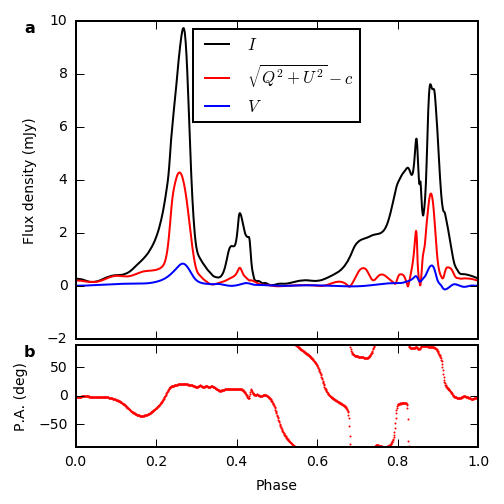

In [65]:
template = "template-work/56412.76_GBT_1400.rmset.scrunch.sm"
off = (0.47,0.5)
T = psrchive.Archive_load(template)
T.convert_state('Stokes')
T.dedisperse()
T.remove_baseline()
t_values = T.get_data()[0,0,0,:]
t_pol = T.get_data()[0,:,0,:]
# shift fundamental to zero phase
a = np.angle(np.fft.fft(t_values)[1])/(2*np.pi)
t_values = pipe.rotate_phase(t_values, -a) 
t_pol = np.array([pipe.rotate_phase(p, -a) for p in t_pol])
t_phases = np.linspace(0,1,len(t_values),endpoint=False)
t_pol, L = ingrid_adjust(t_pol)
#base = t_pol[:,off[0]*len(t_pol):off[1]*len(t_pol)].mean(axis=1)
#t_pol -= base[:,None]
#L = np.hypot(t_pol[1],t_pol[2])
#base_I = t_pol[0,off[0]*len(t_pol):off[1]*len(t_pol)].mean()
#base_L = L[off[0]*len(t_pol):off[1]*len(t_pol)].mean()
#base_V = t_pol[3,off[0]*len(t_pol):off[1]*len(t_pol)].mean()

plt.subplot2grid((4,1),(0,0),rowspan=3)
plt.plot(t_phases,t_pol[0],color='k', label="$I$")
plt.plot(t_phases,L,color='r',label=r"$\sqrt{Q^2+U^2}-c$")
plt.plot(t_phases,t_pol[3]-base_V,color='b',label="$V$")
plt.legend(loc="best")
#plt.title("Template")
#plt.axvline(off[0])
#plt.axvline(off[1])
plt.gca().tick_params("x", labelbottom="off")
plt.ylabel("Flux density (mJy)")
plt.text(-0.1,1,"a",
         horizontalalignment='right',
         verticalalignment='top',
         family='sans-serif',
         size=PANEL_LABEL_SIZE,
         weight='bold',
         transform = plt.gca().transAxes)

plt.subplot2grid((4,1),(3,0))
plt.plot(t_phases,np.degrees(np.arctan2(t_pol[2],t_pol[1])/2),color='r',
         linestyle="none", marker=".",markersize=1)
plt.ylim(-90,90)
plt.xlabel("Phase")
plt.ylabel("P.A. (deg)")
plt.text(-0.1,1,"b",
         horizontalalignment='right',
         verticalalignment='top',
         family='sans-serif',
         size=PANEL_LABEL_SIZE,
         weight='bold',
         transform = plt.gca().transAxes)

plt.gcf().set_size_inches(onecolumn_width,onecolumn_width)
plt.tight_layout(h_pad=0)
plt.savefig("template-baseline.pdf")

In [68]:
np.savetxt("template.csv", 
           np.array((t_phases, t_pol[0], t_pol[1], t_pol[2], t_pol[3])).T, 
           header="phase, I, Q, U, V",
           delimiter=",\t")